# Model Training

## Importing

In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from model.models import Model_1, Model_2, Model_3
from dataloader import DataLoader, DataLoader2
from model.losses import FocalLoss, WBCE, WCCE
from model.callbacks import UpdateAccuracy
from ops import reconstruct_image, recall_precision, compute_mAP
import os
import json
import shutil
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import average_precision_score

## Parameters

In [28]:
# load the params-patches.json options
with open(os.path.join('v1', 'params-patches.json')) as param_file:
    params_patches = json.load(param_file)

# load the params-patches.json options
with open(os.path.join('v1', 'params-training.json')) as param_file:
    params_training = json.load(param_file)
    
#load the params-model.json options
with open(os.path.join('v1', 'params-model.json')) as param_file:
    params_model = json.load(param_file)

#load the shapes.json options
with open('shapes.json') as param_file:
    shapes_json = json.load(param_file)

In [29]:
patches_path = params_patches['patches_path']

train_path = os.path.join(patches_path, params_patches['train_sub'])
val_path = os.path.join(patches_path, params_patches['val_sub'])
test_path = os.path.join(patches_path, params_patches['test_sub'])
full_path = params_patches['full_path']

img_path = params_patches['img_path']
data_raw = os.path.join(img_path, params_patches['data_sub']) 
label_raw = os.path.join(img_path, params_patches['label_sub'])

pred_path = params_patches['pred_path']

## Setting Dataloaders

In [30]:
dl_train = DataLoader2(
    batch_size = params_training['batch_size'],
    data_path=os.path.join(train_path, params_patches['data_sub']),
    label_path=os.path.join(train_path, params_patches['label_sub']),
    patch_size=128,
    opt_bands=8,
    sar_bands=4,
    num_classes=3,
    shuffle=True, 
    limit=params_training['patch_limit']
)

dl_val = DataLoader2(
    batch_size=params_training['batch_size'],
    data_path=os.path.join(val_path, params_patches['data_sub']),
    label_path=os.path.join(val_path, params_patches['label_sub']),
    patch_size=128,
    opt_bands=8,
    sar_bands=4,
    num_classes=3,
    limit=params_training['patch_limit']
)

## Model definition

In [31]:
n_classes = 3
filters = [32, 64, 128]

model = Model_3(filters, n_classes, name='modelo_1')

metrics = {
}

weights = [0.2, 0.8, 0.0]

learning_rate = InverseTimeDecay(
    initial_learning_rate=1e-3, 
    decay_steps=params_training['learning_reduction']*len(dl_train),
    decay_rate = 0.01,
    staircase=True
    )

optimizers = {
    'opt': tf.keras.optimizers.Adam(learning_rate = learning_rate),
    'sar': tf.keras.optimizers.Adam(learning_rate = learning_rate),
    'fusion': tf.keras.optimizers.Adam(learning_rate = learning_rate),
}

class_indexes = [0, 1]

model.compile(
    optimizers = optimizers,
    loss_fn = WBCE,
    metrics_dict = metrics,
    class_weights = weights,
    class_indexes = class_indexes,
    run_eagerly=params_training['run_eagerly']
)

In [32]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_opt_loss',
        patience = params_training['patience'],
        mode = 'min',
        restore_best_weights=True)
]


history = model.fit(
    x=dl_train,
    validation_data=dl_val,
    epochs=params_training['epochs_train'],
    callbacks=callbacks,
    verbose = 1
    )

Epoch 1/200
188/188 [==============================] - 11s 56ms/step - opt_loss: 0.4416 - opt_accuracy: 0.6825 - opt_f1score: 0.2974 - val_opt_loss: 0.3206 - val_opt_accuracy: 0.7983 - val_opt_f1score: 0.3894
Epoch 2/200
188/188 [==============================] - 11s 56ms/step - opt_loss: 0.4331 - opt_accuracy: 0.6936 - opt_f1score: 0.2987 - val_opt_loss: 0.3182 - val_opt_accuracy: 0.8142 - val_opt_f1score: 0.3973
Epoch 3/200
188/188 [==============================] - 11s 58ms/step - opt_loss: 0.4177 - opt_accuracy: 0.7006 - opt_f1score: 0.3425 - val_opt_loss: 0.3223 - val_opt_accuracy: 0.8021 - val_opt_f1score: 0.4710
Epoch 4/200
188/188 [==============================] - 11s 57ms/step - opt_loss: 0.4179 - opt_accuracy: 0.7033 - opt_f1score: 0.3757 - val_opt_loss: 0.3039 - val_opt_accuracy: 0.7846 - val_opt_f1score: 0.3826
Epoch 5/200
188/188 [==============================] - 11s 58ms/step - opt_loss: 0.4091 - opt_accuracy: 0.7069 - opt_f1score: 0.4015 - val_opt_loss: 0.2992 - val_op

## Show training history

In [ ]:
plt.figure(figsize=(15, 8))
x = np.arange(len(history.history['loss']))+1
plt.plot(x, history.history['loss'], 'r-',label='Total Loss')
plt.plot(x, history.history['opt_loss'], 'r:',label='OPT Loss')
plt.plot(x, history.history['sar_loss'], 'r--',label='SAR Loss')
plt.plot(x, history.history['fusion_loss'], 'r-.',label='FUSION Loss')

plt.plot(x, history.history['val_loss'], 'g-',label='Total Val Loss')
plt.plot(x, history.history['val_opt_loss'], 'g:',label='OPT Val Loss')
plt.plot(x, history.history['val_sar_loss'], 'g--',label='SAR Val Loss')
plt.plot(x, history.history['val_fusion_loss'], 'g-.',label='FUSION Val Loss')

plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.savefig('graphics/Loss.png')
plt.show()

In [ ]:
plt.figure(figsize=(15, 8))
x = np.arange(len(history.history['loss']))+1
plt.plot(x, history.history['combined_accuracy'], 'r-',label='Combined Accuracy')
plt.plot(x, history.history['opt_accuracy'], 'r:',label='OPT Accuracy')
plt.plot(x, history.history['sar_accuracy'], 'r--',label='SAR Accuracy')
plt.plot(x, history.history['fusion_accuracy'], 'r-.',label='FUSION Accuracy')

plt.plot(x, history.history['val_combined_accuracy'], 'g-',label='Combined Val Accuracy')
plt.plot(x, history.history['val_opt_accuracy'], 'g:',label='OPT Val Accuracy')
plt.plot(x, history.history['val_sar_accuracy'], 'g--',label='SAR Val Accuracy')
plt.plot(x, history.history['val_fusion_accuracy'], 'g-.',label='FUSION Val Accuracy')

plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.savefig('graphics/Accuracy.png')
plt.show()

In [ ]:
plt.figure(figsize=(15, 8))
x = np.arange(len(history.history['loss']))+1
plt.plot(x, history.history['combined_f1score'], 'r-',label='Combined F1 Score')
plt.plot(x, history.history['opt_f1score'], 'r:',label='OPT F1 Score')
plt.plot(x, history.history['sar_f1score'], 'r--',label='SAR F1 Score')
plt.plot(x, history.history['fusion_f1score'], 'r-.',label='FUSION F1 Score')

plt.plot(x, history.history['val_combined_f1score'], 'g-',label='Combined Val F1 Score')
plt.plot(x, history.history['val_opt_f1score'], 'g:',label='OPT Val F1 Score')
plt.plot(x, history.history['val_sar_f1score'], 'g--',label='SAR Val F1 Score')
plt.plot(x, history.history['val_fusion_f1score'], 'g-.',label='FUSION Val F1 Score')

plt.title('Training F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.savefig('graphics/F1score.png')
plt.show()

## Save weights

In [13]:
model.save_weights('weights.h5')

### Load images

In [33]:
opt = np.load(os.path.join(data_raw, 'opt.npy'))
#sar = np.load(os.path.join(data_raw, 'sar.npy'))

In [34]:
pred = model.predict_from_patches(
    opt, 
    params_patches['patch_size'], 
    params_patches['patch_stride'], 
    16)

100%|██████████| 9990/9990 [01:57<00:00, 84.68it/s]


In [35]:
labels = np.load(os.path.join(label_raw, 'labels.npy'))

C:\Users\FELFER~1\AppData\Local\Temp/ipykernel_11880/836319287.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


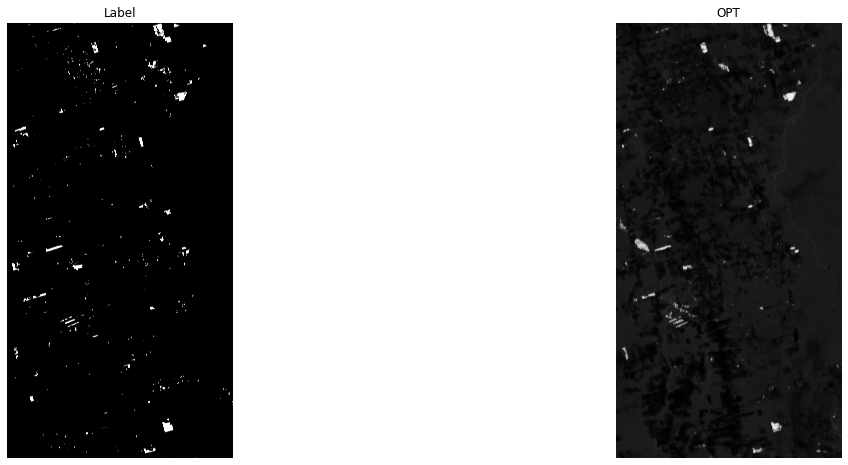

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20,8))


img = Image.fromarray(np.uint8(to_categorical(labels, 3)[:,:,1]*255))
ax[0].axis('off')
ax[0].set_title(f'Label')
ax[0].imshow(img, cmap = 'gray')

img = Image.fromarray(np.squeeze(np.uint8(pred*255)))
ax[1].axis('off')
ax[1].set_title(f'OPT')
ax[1].imshow(img, cmap = 'gray')

fig.show()

In [37]:
shutil.rmtree(pred_path, ignore_errors=True)
os.makedirs(pred_path)

In [38]:
np.save(os.path.join(pred_path, 'opt.npy'), np.squeeze(pred[0]))

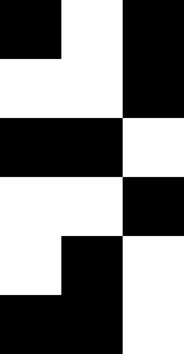

In [41]:
test_mask = np.squeeze(np.zeros_like(pred))
test_tiles = params_patches['test_tiles']
split_v = params_patches['tiles_v']
split_h = params_patches['tiles_h']
lines = np.array_split(range(pred.shape[0]), split_v)
cols = np.array_split(range(pred.shape[1]), split_h)
i = 0
dic = {}
for line in lines:
    for col in cols:
        i+=1
        if i not in test_tiles:
            continue
        test_mask[line[0]:line[-1]+1, col[0]:col[-1]+1] = 1
img = Image.fromarray(np.uint8(test_mask*255))
resize = 0.02
shape = (int(resize*test_mask.shape[1]), int(resize*test_mask.shape[0]))
img = img.resize(shape)
img

In [ ]:
rec_prec_l = []
map_l = []

ref1 = np.ones_like(labels).astype(np.float32)

ref1 [labels == 2] = 0
TileMask = test_mask * ref1
GTTruePositives = labels==1

Npoints = 10
Pmax = np.max(pred[GTTruePositives * TileMask ==1])
Pmin = np.min(pred[GTTruePositives * TileMask ==1])
ProbList = np.linspace(Pmax,Pmin,Npoints) 

rec_pre_metrics = recall_precision(labels, np.squeeze(pred), 625, ProbList,  test_mask)
rec_prec_l.append(rec_pre_metrics)

Recall = rec_pre_metrics[:,0]
Precision = rec_pre_metrics[:,1]

mAP = compute_mAP(Recall, Precision)
map_l.append(mAP)
print(f'mAP({i}): ', mAP)
    
    

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize = (10,10))

plt.plot(rec_prec_l[:,0], rec_prec_l[:,1], 'g-', 'Optical' )


plt.legend(loc='upper right')
plt.grid()
plt.show()